# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import io
import itertools

from IPython.display import Image
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import community

# Functions

In [2]:
def to_simple_graph(G, directed=False):
    """
    Creates new instance Graph simple based on G graph.
    """
    if directed:
        H = nx.DiGraph()
    else:
        H = nx.Graph()
    
    for u,v,d in G.edges(data=True):
        w = d['weight']
        if H.has_edge(u,v):
            H[u][v]['weight'] += w
        else:
            H.add_edge(u,v,weight=w)
    
    return H

In [3]:
nx.Graph.to_simple_graph=to_simple_graph

# Métricas de influencia y conectividad

En el siguiente notebook vamos a ver de forma pŕactica las métricas estudiadas para analizar la conectividad e influencia en una red.

## Read Data

Podemos encontrar el conjunto de datos del notebook en el siguiente link http://vladowiki.fmf.uni-lj.si/doku.php?id=pajek:data:pajek:students

Usaremos un conjunto de grafos descritos así:

>There were 32 students (22 female and 10 male) in the 4th class of Sociology, Social Science Informatics, Faculty of Social Sciences, Ljubljana. Students know each other very well. Several networks were collected using the following questions:

- as1.net: **Suppose you have a birthday next week and you organize a party. Whom would you like to invite to the party? Choose as many students as you wish.**
- as2.net: Suppose there will be an organized trip by bus next week. With whom would you like to sit on the neighboring seats? Choose as many students as you wish.
- as3.net: Whom would you select to inform you about important news in school, if you were out of school because of illness? Choose as many students as you wish.
- as4.net: Sometimes you cannot be present at the lectures. From whom would you like to borrow the teaching material? Choose as many students as you wish.
- as5.net: With whom do you discuss important personal issues? Choose as many students as you wish.
- as6.net: From whom would you borrow small amount of money (e.g. 20 EUR)? Choose as many students as you wish.
- as7.net: With whom do you discuss important personal issues? Choose no more than 3 students.
- as8.net: Suppose you have a birthday next week and you organize a party. Whom would you like to invite to the party? Choose no more than 3 students.
- as9.net: Suppose there will be an organized trip by bus next week. With whom would you like to sit on the neighboring seats? Choose no more than 3 students.
- as10.net: Whom would you select to inform you about important news in school, if you were out of school because of illness? Choose no more than 3 students.
- as11.net: Sometimes you cannot be present at the lectures. From whom would you like to borrow the teaching material? Choose no more than 3 students.
- as12.net: From whom would you borrow small amount of money (e.g. 20 EUR)? Choose no more than 3 students.

Estos ficheros estan en formato `pajek`. Para esta demo se usa el primer fichero as1.net, pero se puede elegir cualquiera

In [4]:
students_graph = nx.read_pajek("data/students/as1.net")

## EDA

Vamos a realizar un análisis exploratorio del grafo, de sus nodos, el número de enlaces y una representación visual

In [5]:
np.array(students_graph.nodes)

array(['z19', 'm28', 'z3', 'z10', 'z7', 'z30', 'm34', 'z22', 'z38', 'z8',
       'z2', 'z26', 'z4', 'm18', 'z31', 'z16', 'm25', 'z35', 'z20', 'm41',
       'm14', 'z40', 'm9', 'z27', 'm32', 'm24', 'z23', 'z37', 'z12',
       'm15', 'z21', 'z11'], dtype='<U3')

In [6]:
len(np.array(students_graph.edges))

220

/home/miguelangel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/miguelangel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


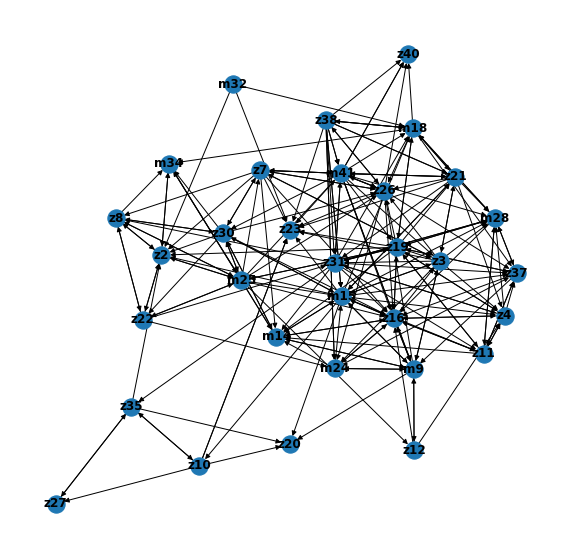

In [7]:
pos=nx.layout.kamada_kawai_layout(students_graph)
fig, ax = plt.subplots(1,1, figsize=(10,10))
nx.draw(students_graph,
        pos=pos,
        with_labels=True, 
        font_weight='bold',
        seed=np.random.seed(42),
        ax=ax)
plt.show()

## Grado

Se conoce como grado de un vértice v, en un grafo no dirigido, al número de aristas incidentes en v. Veamos los vértices de la red ordenados según su grado y la representación de este

In [8]:
d = students_graph.degree()
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

m41    25
m15    25
z16    24
z19    23
z26    19
dtype: int64

Los nodos m41 y m15 son los que tienen mayor grado.

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

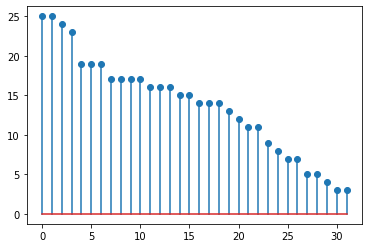

In [9]:
plt.stem(d)

Al representar gráficamente los grados, vemos que hay 4 estudiantes claramente con mayor grado y 4 (los de la derecha del gráfico) con menor grado. Pero no sabemos aún si estos estudiantes de mayor grado son los más populares a los que la gente invita o sin embargo que invitarían a muchos estudiantes a su fiesta.

### Grado IN

Sea v un vértice de un grafo dirigido G:

+ Se denomina grado de entrada (indegree) de v , de(v), al número de arcos cuyo extremo final es v.
+ Se denomina grado de salida (outdegree) de v , ds(v), al número de arcos cuyo extremo inicial es v.

In [10]:
d = students_graph.in_degree()
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

z16    16
z23    11
z26    11
m15    10
m28    10
dtype: int64

In [11]:
d = students_graph.in_degree()
d = pd.Series(dict(d)).sort_values(ascending=True)
d.head()

m32    0
z12    2
z10    2
z38    2
z27    2
dtype: int64

En este caso, los estudiantes con mayor grado de entrada serán los estudiantes más populares a los que la mayoría de alumnos quieren invitar a su fiesta. Vemos que hay claramente un estudiante muy popular, z16. El estudiante más impopular es m32, ya que ningún estudiante le invitaría a su fiesta

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

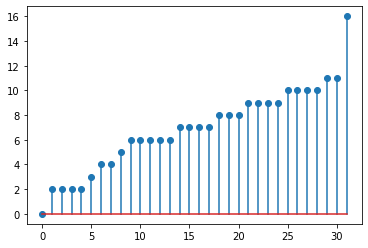

In [12]:
plt.stem(d)

En el gráfico se observa el estudiante más popular frente a 4 estudiantes muy poco populares, que solo serían invitados por dos personas a su fiesta de cumpleaños.

### Grado OUT

In [14]:
d = students_graph.out_degree()
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

m41    18
m15    15
z19    14
z38    14
m25    13
dtype: int64

En este caso los estudiantes que más gente invitarían a su fiesta son los que tenían mayor grado en el primer caso, m41 y m15. Por tanto al desglosar el grado en grado de entrada y de salida queda demostrado que no son estos los estudiantes más populares sino los que invitarían a más personas.

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

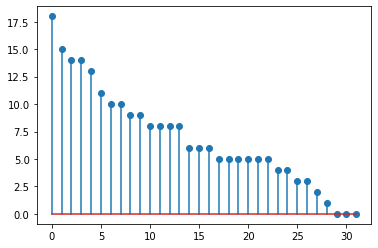

In [15]:
plt.stem(d)

En el gráfico se puede ver que hay tres estudiantes que no invitarían a ningún compañero.

In [16]:
d = students_graph.out_degree()
d = pd.Series(dict(d)).sort_values(ascending=True)
d.head()

z20    0
z40    0
z23    0
z27    1
m34    2
dtype: int64

## Centralidad

Otra métrica importante del análisis de redes es decidir qué vértices son más importantes que otros. La importancia de un vértice depende del tipo de grafo. 

Una de las nociones más simples de centralidad es identificar el centro del grafo. Este está formado por aquellos vértices cuya excentricidad es igual al radio del grafo. Todos los vértices del centro del grafo tienen centralidad máxima.

### Closeness Centrality
Calculo de la suma promedio de las distancias más cortas desde un nodo hacia todos los demás.

In [17]:
nx.algorithms.centrality.closeness_centrality(students_graph,"m41")

0.4079084287200832

In [18]:
d = nx.algorithms.centrality.closeness_centrality(students_graph)
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head(10)

z16    0.549790
z2     0.538092
z23    0.502389
z26    0.495889
m14    0.486352
z19    0.486352
m15    0.477176
m24    0.443690
m28    0.443690
m34    0.443690
dtype: float64

In [19]:
d = nx.algorithms.centrality.closeness_centrality(students_graph)
d = pd.Series(dict(d)).sort_values(ascending=True)
d.head(10)

m32    0.000000
z27    0.284161
z38    0.346443
z35    0.356202
z10    0.361290
z12    0.366526
z40    0.371631
z22    0.371917
z7     0.401434
z21    0.401434
dtype: float64

Observamos que el alumno más popular es aquel que tiene un mayor valor de centralidad y el alumno más impopular el mínimo valor de centralidad

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

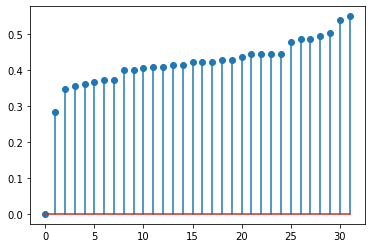

In [20]:
plt.stem(d)

### Betweenness Centrality

Medida que cuantifica la frecuencia o el número de veces que un nodo actúa como un puente a lo largo del camino más corto entre otros dos nodos. La idea intuitiva es que si se eligen dos nodos al azar, y luego también al azar uno de los eventuales posibles caminos más cortos entre ellos, entonces los nodos con mayor intermediación serán aquellos que aparezcan con mayor probabilidad dentro de este camino

In [21]:
students_graph_simple = students_graph.to_simple_graph()

In [22]:
d = nx.algorithms.centrality.betweenness.betweenness_centrality(students_graph_simple)
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

m15    0.138457
z31    0.099536
z2     0.056368
m18    0.051780
z16    0.044330
dtype: float64

In [23]:
d = nx.algorithms.centrality.betweenness.betweenness_centrality(students_graph_simple)
d = pd.Series(dict(d)).sort_values(ascending=True)
d.head()

z27    0.000000
z40    0.000000
z12    0.001523
z11    0.001772
m32    0.001821
dtype: float64

En este caso no es el estudiante más popular el que tiene mayor valor de intermediación. El estudiante m15 es aquel que se relaciona con mayor cantidad diferente de estudiantes

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

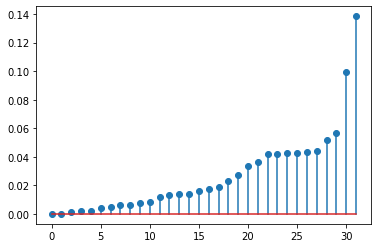

In [24]:
plt.stem(d)

### Eigenvector Centrality

Mide la influencia de un nodo en una red. Los nodos que poseen un valor alto de esta medida de centralidad están conectados a muchos nodos que a su vez están bien conectados, también en este sentido; por lo tanto, son buenos candidatos para difundir información.

In [25]:
d = nx.eigenvector_centrality(students_graph_simple)
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

z16    0.293362
z19    0.267936
m15    0.267650
m41    0.258535
z26    0.251405
dtype: float64

In [26]:
d = nx.eigenvector_centrality(students_graph_simple)
d = pd.Series(dict(d)).sort_values(ascending=True)
d.head()

z27    0.007180
z35    0.039118
m32    0.041018
z20    0.044654
z10    0.044720
dtype: float64

En este caso vemos que el estudiante más popular vuelve a ser un nodo importante. Pero también lo es z19, nodo que tenía un alto grado de centralidad. Aquel con menor influencia es z27, nodo con un bajo valor de intermediación (si se elimina de la red no se cortan caminos entre nodos) y de centralidad, por lo que tiene sentido que no sea un buen candidato para difundir información

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

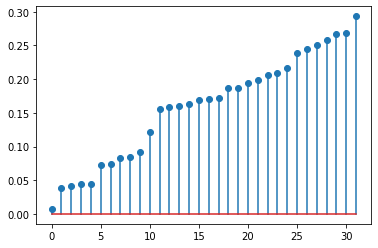

In [27]:
plt.stem(d)

## Influencia

### Page Rank

PageRank de un nodo refleja la importancia del mismo en la red.
Se interpreta un enlace de un nodo A a otro B como un voto, (de A a B). Además se analiza la puntuación del nodo origen, los votos emitidos por nodos "importantes", es decir con un PageRank elevado, valen más, y ayudan a hacer a otros "importantes".

Se suele utilizar para la red Internet y con aristas direccionales, que hacen referencia a los hipervínculos.

In [28]:
d = nx.algorithms.pagerank(students_graph_simple.to_directed())

In [29]:
d = pd.Series(dict(d)).sort_values(ascending=False)
d.head()

m15    0.053280
m41    0.051508
z16    0.049072
z19    0.047025
m25    0.041773
dtype: float64

/home/miguelangel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

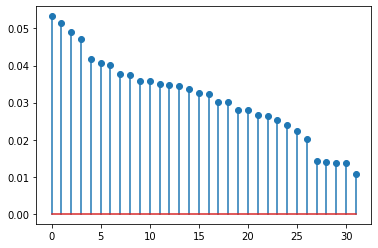

In [30]:
plt.stem(d)

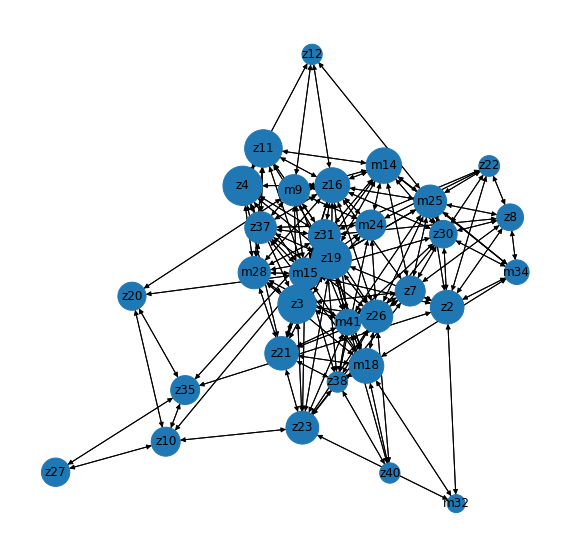

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pos = nx.spring_layout(students_graph_simple.to_directed(),seed = np.random.seed(42))
nx.draw(students_graph_simple.to_directed(),pos=pos,ax=ax,with_labels=True, alpha=1,node_size=d*3E4)

### Hubs & Authorities

+ Hubs estima el valor de un nodo basado en las aristas salientes.
+ Authorities estima el valor de un nodo basado en las aristas entrantes.

Estas métricas tienen sentido en grafos dirigidos

In [32]:
M = nx.generators.directed.random_k_out_graph(10, 3, 1)

In [33]:
G = nx.DiGraph()

for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)

print(G.edges(data=True))

[(0, 4, {'weight': 1.0}), (0, 8, {'weight': 2.0}), (4, 8, {'weight': 3.0}), (8, 1, {'weight': 1.0}), (8, 4, {'weight': 2.0}), (1, 8, {'weight': 2.0}), (1, 2, {'weight': 1.0}), (2, 8, {'weight': 1.0}), (2, 3, {'weight': 1.0}), (2, 6, {'weight': 1.0}), (3, 7, {'weight': 1.0}), (3, 4, {'weight': 2.0}), (6, 8, {'weight': 2.0}), (6, 3, {'weight': 1.0}), (7, 8, {'weight': 1.0}), (7, 4, {'weight': 1.0}), (7, 1, {'weight': 1.0}), (5, 7, {'weight': 1.0}), (5, 8, {'weight': 1.0}), (5, 1, {'weight': 1.0}), (9, 8, {'weight': 1.0}), (9, 9, {'weight': 2.0})]


/home/miguelangel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/miguelangel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


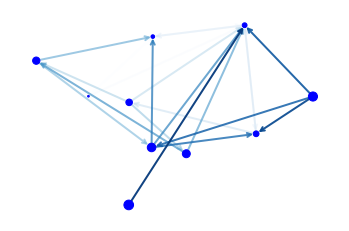

In [34]:
pos = nx.layout.spring_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue', with_labels=True)
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [36]:
df_ = nx.algorithms.hits(G)
pd.DataFrame(df_, index=("hub","authorities")).T.sort_values(by="hub",ascending=False)

,hub,authorities
4,0.196624,0.121127
0,0.144713,0.000000
6,0.139173,0.025500
1,0.136191,0.066120
7,0.086612,0.036124
9,0.077111,0.051407
5,0.077047,0.000000
2,0.076501,0.045397
8,0.034701,0.582433
3,0.031326,0.071891


In [37]:
G.in_degree(weight='weight')

InDegreeView({0: 0, 4: 6.0, 8: 13.0, 1: 3.0, 2: 1.0, 3: 2.0, 6: 1.0, 7: 2.0, 5: 0, 9: 2.0})

In [38]:
nx.ego_graph(G=G, n=6, radius=1).edges

OutEdgeView([(6, 8), (6, 3)])

In [41]:
_ = nx.algorithms.hits(students_graph_simple.to_directed())
pd.DataFrame(_, index=("hub","authorities")).T.sort_values(by="authorities",ascending=False).head()

,hub,authorities
m41,0.059280,0.059280
z16,0.057347,0.057347
z19,0.055484,0.055484
m15,0.054028,0.054028
z26,0.046710,0.046710


# Detección de Comunidades

Una red tiene estructura de comunidades si los nodos de pueden ser fácilmente agrupados en grupos que pueden estar superpuestos. Si se buscan comunidades no superpuestas, la red se divide de forma natural en grupos densamente conectados internamente y con pocas conexiones entre grupos.

https://networkx.github.io/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community

## Buscar comunidades Bipartitas
Se particiona el grafo en 2 bloques, usando el algoritmo de *Kernighan–Lin*.

In [42]:
comunities = nx.algorithms.community.kernighan_lin.kernighan_lin_bisection(students_graph_simple)

/home/miguelangel/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


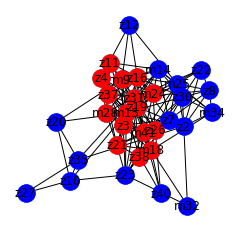

In [43]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
pos = nx.spring_layout(students_graph_simple,seed = np.random.seed(42))
nx.draw(students_graph_simple,pos=pos,ax=ax,with_labels=True, alpha=1)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=comunities[0],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       node_color="r",
                       label=True,
                       ax=ax)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=comunities[1],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       node_color="b",
                       ax=ax)

Lo representamos directamente en layout bipartito

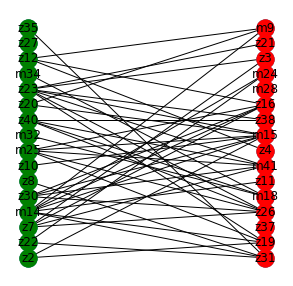

In [44]:
pos = nx.layout.bipartite_layout(students_graph_simple,nodes=comunities[1])

fig, ax = plt.subplots(1,1,figsize=(5,5))

nx.draw(students_graph_simple,pos=pos,ax=ax,with_labels=True, alpha=1)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=comunities[0],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       node_color="r",
                       label=True,
                       ax=ax)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=comunities[1],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       node_color="g",
                       ax=ax)

Vemos como se detectan dos comunidades, que hemos representado en un grafo bipartito. A rasgos generales, agrupa en una comunidad a los alumnos con nodos más importantes y en otra los menos importantes

## k-clique communities

Sea G un grafo no dirigido. Dos cliques C1 y C2 se dicen que son adyacentes si tienen al menos **k-1** vértices en común. Una k-clique comunidad de G es la unión de k-cliques tal que para cada dos cliques hay una serie en la cual ambos son cliques adyacentes.

In [45]:
nx.clique.graph_clique_number(students_graph_simple)

7

Buscamos 6-cliques comunidades

In [46]:
k_6_communities = list(nx.algorithms.community.kclique.k_clique_communities(students_graph_simple,k=6))

Pintamos los cliques encontrados en el conjunto

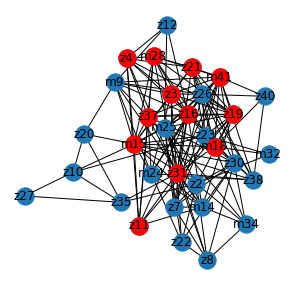

In [47]:
pos = nx.layout.kamada_kawai_layout(students_graph_simple)

fig, ax = plt.subplots(1,1,figsize=(5,5))

nx.draw(students_graph_simple,pos=pos,ax=ax,with_labels=True, alpha=1)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=k_6_communities[0],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       seed=np.random.seed(42),
                       node_color="r",
                       label=True,
                       ax=ax)

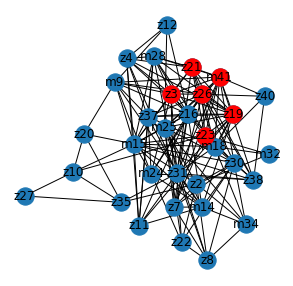

In [48]:
pos = nx.layout.kamada_kawai_layout(students_graph_simple)

fig, ax = plt.subplots(1,1,figsize=(5,5))

nx.draw(students_graph_simple,pos=pos,ax=ax,with_labels=True, alpha=1)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=k_6_communities[1],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       seed=np.random.seed(42),
                       node_color="r",
                       label=True,
                       ax=ax)

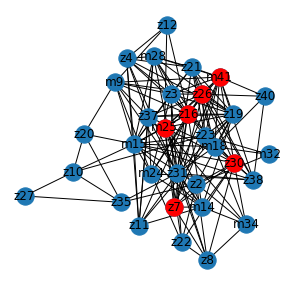

In [49]:
pos = nx.layout.kamada_kawai_layout(students_graph_simple)

fig, ax = plt.subplots(1,1,figsize=(5,5))

nx.draw(students_graph_simple,pos=pos,ax=ax,with_labels=True, alpha=1)
nx.draw_networkx_nodes(students_graph_simple,
                       nodelist=k_6_communities[2],
                       with_labels=True, 
                       font_weight='bold',
                       pos=pos,
                       seed=np.random.seed(42),
                       node_color="r",
                       label=True,
                       ax=ax)